In [19]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
from keras import backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint


In [2]:
TRAIN_CSV = "dutch_data/dutch_formatted_as_csv.csv"
EMBEDDING_FILE = 'wiki.nl/wiki.nl.vec'


train_df = pd.read_csv(TRAIN_CSV)

In [3]:
row_count = sum(1 for row in train_df)
#print(train_df)

In [4]:
def substitute_thousands(text):
    matches = re.finditer(r'[0-9]+(?P<thousands>\s{0,2}k\b)', text, flags=re.I)
    result = ''
    len_offset = 0
    for match in matches:
        result += '{}000'.format(text[len(result)-len_offset:match.start('thousands')])
        len_offset += 3 - (match.end('thousands') - match.start('thousands'))
    result += text[len(result)-len_offset:]
    return result

tests = ['another 15K keys', 'more 60 k keys', 'a 20 keys', 'no 10keys', '2k and another 3 k for me', '10K.']
for test in tests:
    print(substitute_thousands(test))

another 15000 keys
more 60000 keys
a 20 keys
no 10keys
2000 and another 3000 for me
10000.


In [5]:
nltk.download('stopwords')
print("begin sets")
stops = set(stopwords.words('dutch'))
print("end sets")

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = substitute_thousands(text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)

    text = text.split()

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
begin sets
end sets


In [6]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']  
# '<unk>' will never be used, it is only a placeholder for the 
# [0, 0, ....0] embedding

print("loading word2vec")
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=False)
print("done loading word2vec")

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions with lists of word indices
            dataset.set_value(index, question, q2n)
            

embedding_dim = 300
# This will be the embedding matrix
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  
embeddings[0] = 0  # So that the padding will be ignored


# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)            

loading word2vec
done loading word2vec


In [7]:
from keras.callbacks import Callback
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [9]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),train_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 1000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [17]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [58]:
from keras.layers import Bidirectional
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 10

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

c:\python35\lib\site-packages\ipykernel\__main__.py:29: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
c:\python35\lib\site-packages\ipykernel\__main__.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8998 samples, validate on 1000 samples
Epoch 1/25
6656/8998 [=====================>........] - ETA: 35s - loss: 0.3083 - acc: 0.6558 

KeyboardInterrupt: 

[0.33870606899261474, 0.33343324613571168, 0.32990540075302122, 0.32773208832740786, 0.32618005681037904]


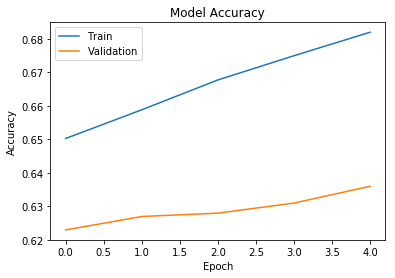

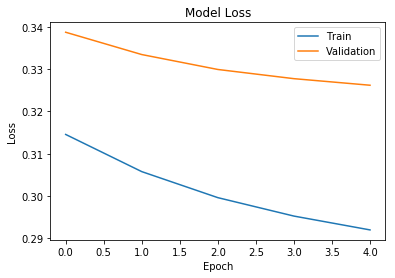

In [34]:
# Plot accuracy
print(malstm_trained.history['val_loss'])

plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()